In [ ]:
# Importar librerías

import pandas as pd
import matplotlib as mlt
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Coordenadas de mundo
nm = 1e-9
um = 1e-6
mm = 1e-3
cm = 1e-2

# Longitud de onda
w_length = 533*nm

fTL = 200 * mm
M = 10

fMO = - fTL / M


# Diferenciales, como N y M pendientes por definir para una imagen
dx = dy = 1*um # los diferenciales (tamaño de pixel)

In [ ]:
def fun_ploteo_complejo(mat, indicador, escala, mapa_color = 'gray'):
    """
    mat  es una matriz compleja a plotear
    indicador = I para intensidad, A para amplitud, P para fase
    escala = 1 para nada, 0 para logarítmica
    """

    if(indicador =="I"):
        mat = np.abs(mat)**2
    elif(indicador == "A"):
        mat = np.abs(mat)
    elif(indicador == "P"):
        mat = np.angle(mat)

    if (escala == 1):
        plt.figure()
        plt.imshow(mat, cmap = mapa_color)
        plt.colorbar()
        plt.show()
    else:    
        plt.figure()
        plt.imshow( np.log( mat + 0.000000001), cmap = mapa_color)
        plt.colorbar()
        plt.show()

    return 

In [ ]:
# Función para "Pading"
def fun_pad(campo, tipo = 'c'):
    '''
    fun_pad es una función que "padea" un campo (imagen) 2D con ceros tal que duplica su longitud y altura

    Solo recibe imágenes de 1 canal

    Variables de entrada:
     - campo: (numpy.ndarray) ; es el campo a padear de L_x y L_y dimensiones físicas reales
     - tipo: (str) ; c = pad cuadrado, de lado y lado con la dimensión máxima de campo
                     o = pad rectangualr teniendo en cuenta las dimensiones de campo

    Variables de salida:
     - campo_paded: (numpy.ndarray) ; es el campo padeado con ceros de dimensiones 2*L_x y 2*L_y 
    '''

    
    if tipo == 'c':
        dim_max = max(np.shape(campo))
        
        dimension_pad = np.ceil(np.array( [ int(2*dim_max-np.shape(campo)[0]) , int(2*dim_max-np.shape(campo)[1]) ] ) / 2)
        campo_paded = np.pad(campo, ( (int(dimension_pad[0]), int(dimension_pad[0])-1 ), (int(dimension_pad[1]), int(dimension_pad[1]) ) ), mode = 'constant', constant_values = (0,0) )
    

    else:
        # extraer las dimensiones del pad
        dimension_pad = np.array( [np.shape(campo)[0] , np.shape(campo)[1] ] ) / 2

    # padear el campo con ceros
        campo_paded = np.pad(campo, ( (int(dimension_pad[0]), int(dimension_pad[0]) ), (int(dimension_pad[1]), int(dimension_pad[1])) ), mode = 'constant', constant_values = (0,0) )

    return (campo_paded)

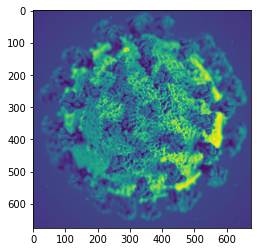

(675, 675)

In [ ]:
Muestra = cv2.imread('MO.jpeg',0)
plt.figure()
plt.imshow(Muestra)
plt.show()
np.shape(Muestra)

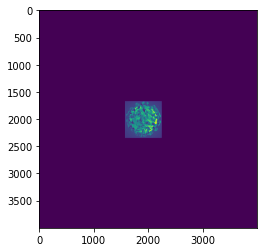

(4000, 4000)

In [ ]:
Padeada = cv2.imread('Padeada.png', 0)
plt.figure()
plt.imshow(Padeada)
plt.show()
np.shape(Padeada)

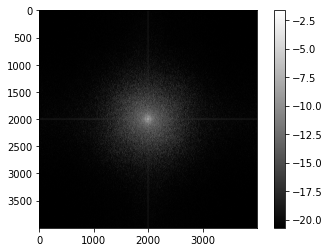

In [ ]:
Transformada_MO = (np.fft.fftshift(np.fft.fftn(Padeada))) * (1/1j * w_length * fMO)
fun_ploteo_complejo(Transformada_MO, "I", 0)

In [ ]:
def opening(dx, dy, radio):

  N,M = (4000,4000)
  x = np.arange(-int(M/2), int(M/2), 1)
  y = np.arange(-int(N/2), int(N/2), 1)
  
  fx = x * dx
  fy = y * dy
  
  X,Y = np.meshgrid(fx, fy)
  circulo = np.array(X**2 + Y**2 <= radio**2, dtype = bool)
  plt.imshow(circulo)
  plt.colorbar()
  plt.show()

  return circulo

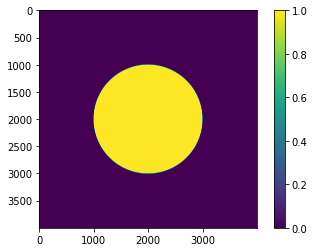

In [ ]:
Abertura = opening(dx, dy, 1*mm)

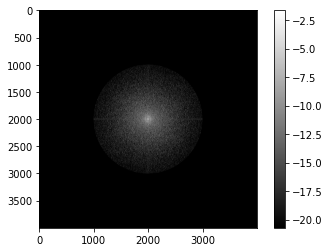

In [ ]:
Convolucion = Transformada_MO * Abertura
fun_ploteo_complejo(Convolucion, "I", 0)

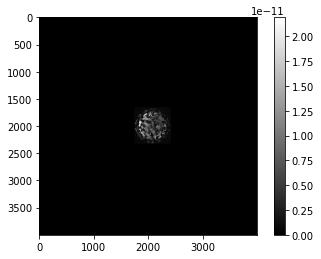

In [24]:
Transformada_TL = (np.fft.fftn(Convolucion)) * (1j * w_length * fTL)
fun_ploteo_complejo(Transformada_TL, "I", 1)

In [40]:
def matriz_transferencia(campo, A, B, D, L_0, w_length):
    k_vect = 2*np.pi/w_length

    dy = 1*um

    #Definamos el espacio coordenado
    N,M = np.shape(campo)
    x = np.arange(-int(np.floor(N/2)), int(np.ceil(N/2)), 1)
    y = np.arange(-int(np.floor(N/2)), int(np.ceil(N/2)), 1)
    X, Y1 = np.meshgrid(x,y)

    X, Y2 = np.meshgrid(x,y)

    U_y2 = np.zeros(np.shape(campo), dtype = np.complex128 ) 

    suma = 0
    for y2 in np.arange(M):
        for y1 in np.arange(M):
            suma += np.exp(1j*k_vect*L_0) * np.exp(1j*k_vect * D* (dy*Y2[:,y2])**2/ (2*B)) * campo[:, y1]* np.exp(1j*k_vect*A/(2*B)* dy**2*(Y1[:, y1])**2) * np.exp(-1j*k_vect/B * dy**2 *Y1[:,y1]*Y2[:,y2])
        U_y2[:,y2] = suma
        suma=0

    return U_y2

In [41]:
d1 = matriz_transferencia(Padeada, 0, fMO, 0,2*fMO, w_length) #No sabemos si funciona porqué no tuvimos tiempo de correrlo, se demora mucho porqué la imagen es muy grande

KeyboardInterrupt: ignored

In [ ]:
con = d1 * Abertura

In [ ]:
d2 = matriz_transferencia(d1,0, fTL, 0, 2*fTL, w_length )
fun_ploteo_complejo(d2, "I", 1)